In [27]:
import os

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()

In [28]:
# project files
from rp_model.files import set_files_directory

set_files_directory("./files")

from rp_model.calc import (
    game, FitOptions, download_data, refresh_pokedex, compute_rp, make_precomputed_columns, make_initial_guess
)
from rp_model.utils import (
    pack, unpack, table, DataStore, truncate
)

In [29]:
# stuff for display

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [30]:
refresh_rp_file = True

if refresh_rp_file:
    refresh_pokedex()
    data = download_data()
    data.to_pickle(FitOptions.data_file)
else:
    data = pd.read_pickle(FitOptions.data_file)

In [31]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,Berry1,Ing1P,MiscMult,NrgNat,Helps per hour,IngrMult,SkillMult,BerryD,IngD,SklVal,FreqL,HelpNat,IngrNat,Ingr%,SkillNat,Skill%,BerryL,Dupes,Diff -0.1% ingr,Diff +0.1% ingr,Diff,Amnt,Ing2P,RP Multiplier,HelpSub,IngrSub,SkillSub
count,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.0,11554.000000,11554.000000,11554.000000,11554.000000,11554.000000,11554.00000,11554.000000,11554.000000,11554.000000
mean,15.048468,805.865674,1.681322,805.866194,0.000519,3764.419249,28.172927,108.696296,1.038057,0.993602,1.102507,0.211110,0.038623,65.065086,155.064134,986.653021,3571.361807,0.987459,0.999013,0.203717,1.009174,0.036322,42.910334,1.0,-0.642043,0.632172,-0.004821,0.261554,12.728233,1.04547,0.981310,1.031781,1.041440
std,10.125128,629.273067,1.158466,629.272971,0.022783,1012.654407,2.734833,15.892026,0.095504,0.044134,0.347676,0.058411,0.021862,38.867090,70.316196,916.572455,1080.397786,0.056907,0.117369,0.040567,0.120124,0.018791,12.603066,0.0,0.787346,0.791708,0.288480,0.882305,40.056435,0.08654,0.045267,0.095819,0.108318
min,1.000000,245.000000,1.000000,245.000000,0.000000,2100.000000,24.000000,90.000000,0.920000,0.920000,0.520000,0.100800,0.006400,25.000000,90.000000,400.000000,1407.780000,0.900000,0.800000,0.126000,0.800000,0.008000,24.000000,1.0,-8.430000,-1.180000,-0.500000,0.000000,0.000000,1.00000,0.790000,1.000000,1.000000
25%,8.000000,394.000000,1.000000,394.000000,0.000000,2800.000000,26.000000,98.000000,1.000000,1.000000,0.820000,0.169600,0.021000,39.000000,101.000000,400.000000,2656.800000,1.000000,1.000000,0.174000,1.000000,0.021000,34.000000,1.0,-0.910000,0.140000,-0.250000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
50%,12.000000,583.500000,1.000000,584.000000,0.000000,3700.000000,28.000000,103.000000,1.000000,1.000000,1.040000,0.203000,0.036000,53.000000,121.000000,880.000000,3430.000000,1.000000,1.000000,0.201000,1.000000,0.036000,40.000000,1.0,-0.500000,0.480000,0.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
75%,21.000000,946.000000,2.000000,946.000000,0.000000,4400.000000,31.000000,121.000000,1.080000,1.000000,1.350000,0.247900,0.051600,76.000000,206.000000,1083.000000,4356.000000,1.000000,1.000000,0.230000,1.000000,0.047000,48.000000,1.0,-0.160000,0.910000,0.240000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000
max,55.000000,5473.000000,7.000000,5473.000000,1.000000,6300.000000,35.000000,151.000000,1.550000,1.080000,2.550000,0.517400,0.217100,354.000000,511.000000,12438.000000,6916.140000,1.100000,1.200000,0.339000,1.200000,0.141000,118.000000,1.0,0.950000,7.840000,0.510000,8.000000,342.000000,1.44200,1.000000,1.540000,1.540000


,Pokemon,Level,RP,NatureEN/ZH,MS lvl,Source,ModelRP,Difference,Nature,ID,NatureP,NatureN,Type,Class,MSkill,Freq1,Berry1,Ing1,Ing1P,MiscMult,NrgNat,Helps per hour,IngrMult,SkillMult,BerryD,IngD,SklVal,FreqL,HelpNat,IngrNat,Ingr%,SkillNat,Skill%,BerryL,Dupes,DupeMatch,Diff -0.1% ingr,Diff +0.1% ingr,Diff,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,RP Multiplier,HelpSub,IngrSub,SkillSub,Sub Skill 3
0,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,531.0,0.0,Neutral,ArbokNeutral81,-,-,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,1.00,0.98,0.2640,0.0570,78.0,103.0,400.0,3648.20,1.0,1.0,0.26,1.0,0.057,39,1,True,-0.4900,-0.2200,-0.3600,,,,0.0,0.0,1.0,1.0,1.0,1.0,
1,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.0,0.0,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,1.00,0.98,0.3168,0.0570,78.0,103.0,400.0,3648.20,1.0,1.2,0.26,1.0,0.057,39,1,True,-0.1400,0.1300,-0.0100,,,,0.0,0.0,1.0,1.0,1.0,1.0,
2,Arbok,9.0,528.0,Bold,1.0,,528.0,0.0,Bold,ArbokBold91,Energy Recovery,Speed of Help,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.08,1.08,0.89,0.2640,0.0570,80.0,103.0,400.0,4004.88,1.1,1.0,0.26,1.0,0.057,40,1,True,0.1956,0.4548,0.3252,,,,0.0,0.0,1.0,1.0,1.0,1.0,
3,Arbok,9.0,539.0,Hardy,1.0,Double Jumper,539.0,0.0,Neutral,ArbokNeutral91,-,-,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,1.00,0.98,0.2640,0.0570,80.0,103.0,400.0,3640.80,1.0,1.0,0.26,1.0,0.057,40,1,True,-0.4700,-0.2000,-0.3400,,,,0.0,0.0,1.0,1.0,1.0,1.0,
4,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.0,0.0,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,Poison,Berries,Charge Energy S,3700.0,32.0,Bean Sausage,103.0,1.00,1.00,1.09,0.2640,0.0456,80.0,103.0,400.0,3276.72,0.9,1.0,0.26,0.8,0.057,40,1,True,0.1200,0.4100,0.2600,,,,0.0,0.0,1.0,1.0,1.0,1.0,


In [32]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(*make_initial_guess())
computed = make_precomputed_columns(data)


In [33]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)


def residual(x):
    return data["RP"].to_numpy() - RP(x)

In [34]:
# Add 10% noise to test recovering initial values.
# x0 = x0 * (1 + 0.1 * ( np.random.rand(len(x0)) - 0.5 ) )

count    11554.000000
mean         0.002164
std          0.051755
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RP, dtype: float64

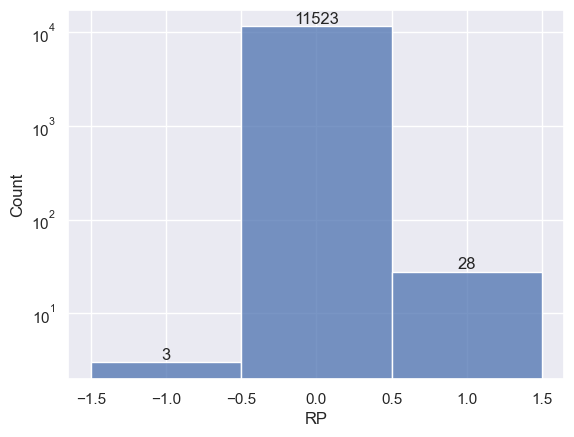

In [35]:
# what is the quality of the initial guess?

r = data["RP"] - np.round(RP(x0))
pd.Series(r).describe()

_ = plt.figure()
g = sns.histplot(x=r, discrete=1)
_ = g.axes.set_yscale('log')

if(g.containers and len(g.containers) > 0):
    _ = g.bar_label(g.containers[-1], labels=[str(v) if v else '' for v in g.containers[-1].datavalues])

 Derivative-Free Optimization for Least-Squares (DFO-LS) is a
 nonlinear least-squares solver that only requires function values.

 Documentation
 [https://numericalalgorithmsgroup.github.io/dfols/build/html/index.html](https://numericalalgorithmsgroup.github.io/dfols/build/html/index.html)

 Repository
 [https://github.com/numericalalgorithmsgroup/dfols](https://github.com/numericalalgorithmsgroup/dfols)

 Install using either:
 `conda install -c conda-forge dfo-ls`
 `pip install DFO-LS`

In [36]:
from dfols import solve as dfols_solve

cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

store = (DataStore(FitOptions.result_file)
         .with_dependency_on(data, x0)
         .try_read_and_validate()
         )

if cache_fit and store.is_valid() :
    opt = store.data()
    print("Loaded from cache")

else:



    #opt = scipy.optimize.least_squares(residual, x0, **FitOptions.least_squares_kwargs)
    opt = dfols_solve(residual, x0, print_progress=True, maxfun=1500, rhoend=1.5e-4)


    # save results and remove some stuff we don't need to save.
    store.use_data(opt).save_to_path()

opt.msg

 Run  Iter     Obj       Grad     Delta      rho     Evals 
  1     1    3.10e+01  4.96e+03  1.83e-01  1.83e-01   269  
  1     2    3.10e+01  4.96e+03  9.14e-02  1.83e-02   269  
  1     3    3.10e+01  4.96e+03  2.74e-02  1.83e-02   270  
  1     4    3.10e+01  4.96e+03  2.74e-02  1.83e-02   271  
  1     5    3.10e+01  4.96e+03  2.74e-02  1.83e-02   272  
  1     6    3.10e+01  4.96e+03  2.74e-02  1.83e-02   273  
  1     7    3.10e+01  4.96e+03  2.74e-02  1.83e-02   274  
  1     8    3.10e+01  4.96e+03  2.74e-02  1.83e-02   275  
  1     9    3.10e+01  4.96e+03  2.74e-02  1.83e-02   276  
  1    10    3.10e+01  4.96e+03  2.74e-02  1.83e-02   277  
  1    11    3.10e+01  4.96e+03  2.74e-02  1.83e-02   278  
  1    12    3.10e+01  4.96e+03  2.74e-02  1.83e-02   279  
  1    13    3.10e+01  4.96e+03  2.74e-02  1.83e-02   280  
  1    14    3.10e+01  4.96e+03  2.74e-02  1.83e-02   281  
  1    15    3.10e+01  4.96e+03  2.74e-02  1.83e-02   282  
  1    16    3.10e+01  4.96e+03  2.74e-0

'Success: rho has reached rhoend'

In [37]:
table(opt)

EXIT_FALSE_SUCCESS_WARNING,3
EXIT_INPUT_ERROR,-1
EXIT_LINALG_ERROR,-3
EXIT_MAXFUN_WARNING,1
EXIT_SLOW_WARNING,2
EXIT_SUCCESS,0
EXIT_TR_INCREASE_ERROR,-2
diagnostic_info,None
f,31.0
flag,0
jacobian,[[ 1.60299514e+04 1.50973220e+04 1.57023161e+04 ... 4.45072777e+03 -8.20626618e+03 1.23420171e+04] [ 1.60299514e+04 1.50973220e+04 1.57023161e+04 ... 4.45072777e+03 -8.20626618e+03 1.23420171e+04] [ 1.60299514e+04 1.50973220e+04 1.57023161e+04 ... 4.45072777e+03 -8.20626618e+03 1.23420171e+04] ... [ 1.08914368e+05 4.47242924e+05 7.23441745e+04 ... 4.67868824e+05 -2.50290845e+05 4.13053281e+05] [ 2.27253273e+04 4.17599863e+04 1.88575041e+04 ... 1.26155384e+04 -4.64222335e+04 3.43713098e+04] [ 2.50541721e+04 3.09740469e+04 5.37030740e+04 ... 4.44429395e+04 6.11002649e+02 -1.78062023e+02]]


count    11554.000000
mean         0.002164
std          0.051755
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: RP, dtype: float64

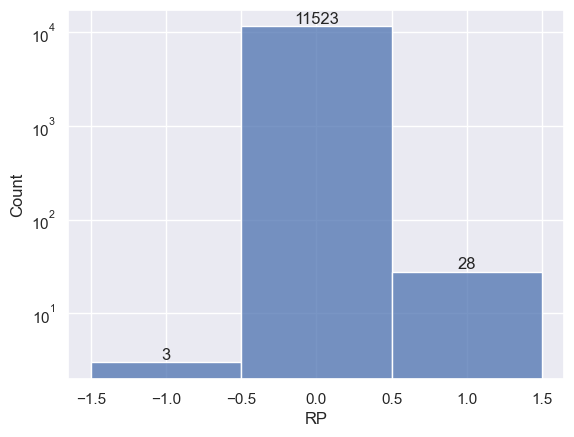

In [38]:
r_opt = data["RP"] - np.round(RP(opt.x))
pd.Series(r_opt).describe()


_ = plt.figure()
g = sns.histplot(x=r_opt, discrete=1)
_ = g.axes.set_yscale('log')

if(g.containers and len(g.containers) > 0):
    _ = g.bar_label(g.containers[-1], labels=[str(v) if v else '' for v in g.containers[-1].datavalues])


In [39]:
sol = unpack(opt.x, unpack_info)
table(sol)

Pokemons ing fractions,[0.257 0.255 0.266 ... 0.229 0.139 0.165]
Pokemons skill chances,[0.019 0.019 0.021 ... 0.013 0.022 0.033]


In [40]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({
    "Pokemon": game.data.pokedex["Pokemon"],
    "ing%": truncate( sol["Pokemons ing fractions"] * 100.0, 1),
    "skill%": truncate( sol["Pokemons skill chances"] * 100.0, 2)
})
res.set_index("Pokemon")

,ing%,skill%
Pokemon,,
Bulbasaur,25.7,1.90
Ivysaur,25.5,1.90
Venusaur,26.6,2.09
Charmander,20.1,1.09
Charmeleon,22.7,1.60
...,...,...
Dedenne,17.7,4.50
Stufful,22.5,1.09
Bewear,22.9,1.30


In [41]:
# What are the worst points?

df = data[["Pokemon", "ID", "Level", "MS lvl", "NatureP", "NatureN", "Sub Skill 1", "Sub Skill 2", "RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = data["RP"] - np.round(RP(opt.x))
df["error2"] = df["error"] ** 2

df = df.sort_values("error2", ascending=False).reset_index(drop=True)
df.head(100)


,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
0,Pichu,PichuQuiet11,1.0,1.0,Ingredient Finding,Exp Gains,,,288.0,287.0,1.0,1.0
1,Butterfree,ButterfreeNeutral155Ingredient Finder M,15.0,5.0,-,-,Ingredient Finder M,,931.0,930.0,1.0,1.0
2,Pikachu,PikachuNeutral61,6.0,1.0,-,-,,,503.0,502.0,1.0,1.0
3,Mankey,MankeyNeutral121Ingredient Finder S,12.0,1.0,-,-,Ingredient Finder S,,403.0,402.0,1.0,1.0
4,Eevee,EeveeSassy151Inventory Up S,15.0,1.0,Main Skill Chance,EXP Gains,Inventory Up S,,601.0,602.0,-1.0,1.0
5,Diglett,DiglettCareful71,7.0,1.0,Main Skill Chance,Ingredient Finding,,,313.0,312.0,1.0,1.0
6,Abomasnow,AbomasnowHasty201Berry Finding S,20.0,1.0,EXP Gains,Energy Recovery,Berry Finding S,,893.0,892.0,1.0,1.0
7,Rattata,RattataBold151Ingredient Finder S,15.0,1.0,Energy Recovery,Speed of Help,Ingredient Finder S,,366.0,367.0,-1.0,1.0
8,Vaporeon,VaporeonCareful52,5.0,2.0,Main Skill Chance,Ingredient Finding,,,805.0,804.0,1.0,1.0
9,Pichu,PichuMild11,1.0,1.0,Ingredient Finding,Energy Recovery,,,265.0,264.0,1.0,1.0
